# **Deep Learning Project** - Aerial Perspective Object Detection
SEP 769 - Group 2

In [1]:
#About semantic segmentation: https://www.jeremyjordan.me/semantic-segmentation/
#TF Tutorial: https://www.tensorflow.org/tutorials/images/segmentation
#TF load and process images: https://www.tensorflow.org/tutorials/load_data/images

#Different image nets: https://medium.com/analytics-vidhya/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5
#TF Resnet: 


from google.colab import drive
import tensorflow as tf
import tensorflow_datasets as tfds
drive.mount('/content/gdrive')
import cv2
import glob
import numpy as np
import os
import fnmatch
from matplotlib import pyplot as plt

if not os.path.exists("/content/gdrive/Shareddrives/SEP_769/data/drone_data/"):
  !unzip "/content/gdrive/Shareddrives/SEP_769/drone_data.zip" -d "/content/gdrive/Shareddrives/SEP_769/data"

#image1 = cv2.imread('{}000.jpg'.format(original_images_path)) #original size image
#image2 = cv2.resize(cv2.imread('{}000.jpg'.format(original_images_path), flags=1), (0,0), fx=0.05, fy=0.05)  #smaller image
#print(image1.shape)
#print(image2.shape)

#print('\nTotal of {} images at path: \n{}\n\n'.format(image_count, original_images_path))

#40 for test
#360 for train

#pixel accuracy, Intersection over Union (IOU)


Mounted at /content/gdrive


#*Constants and Functions*

In [2]:
original_images_path = '/content/gdrive/Shareddrives/SEP_769/data/drone_data/original_images/'
original_semantic_path = '/content/gdrive/Shareddrives/SEP_769/data/drone_data/label_images_semantic/'
HEIGHT = 200
WIDTH = 300
EPOCHS = 50
BATCHSIZE = 3
VAL_SPLIT = 0.9

# reads images from dir, resizes and returns np array
# optional file type argument ext
def images_to_array(dir, width, height, ext='.jpg'):
  data = []
  files = os.listdir(dir)
  files.sort()
  for filename in files:
    if filename.endswith(ext):
      img = cv2.imread(dir+filename,flags=1)
      img = cv2.resize(img, (width, height))
      data.append(img)

  return np.array(data)

def labels_to_array(dir, width, height, ext='.jpg'):
  data = []
  files = os.listdir(dir)
  files.sort()
  for filename in files:
    if filename.endswith(ext):
      img = cv2.imread(dir+filename,flags=0)
      img = cv2.resize(img, (width, height))
      data.append(img)

  return np.array(data)

# displays a number of originals with their masks
def display_images(images):
  plt.figure(figsize=(15,10))
  for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    if len(images[i].shape) == 3:
      plt.imshow(images[i])
    else:
      plt.imshow(images[i], cmap="gray", vmin=0, vmax=255)
  plt.show()



#plt.imshow(original_images[0])
#plt.show()
#print(original_images[0].shape)
#plt.imshow(semantic_images[0])
#plt.show()
#print(semantic_images[0].shape) 

#Prepping Import Data

In [3]:
images = images_to_array(original_images_path, width=WIDTH, height=HEIGHT)
print(images.shape)

labels = labels_to_array(original_semantic_path, width=WIDTH, height=HEIGHT, ext='png')
print(labels.shape)



#Old Image Import
#original_images = [cv2.resize(cv2.imread(file, flags=1), (0,0), fx=0.05, fy=0.05) for file in glob.glob('{}*.jpg'.format(original_images_path))]  #importing images in color at 5% scale
#semantic_images = [cv2.resize(cv2.imread(file, flags=0), (0,0), fx=0.05, fy=0.05) for file in glob.glob('{}*.png'.format(original_semantic_path))]  #importing images segmented
#print(original_images.shape)
#print(semantic_images.shape)

#image_count = len(fnmatch.filter(os.listdir(original_images_path), '*.jpg'))
#print('\nTotal of {} images at path: \n{}\n\n'.format(image_count, original_images_path))
#image_count = len(fnmatch.filter(os.listdir(original_semantic_path), '*.png'))
#print('\nTotal of {} images at path: \n{}\n\n'.format(image_count, original_semantic_path))


(400, 200, 300, 3)
(400, 200, 300)


In [4]:
train_images, test_images = tf.split(images, [360,40])
print(train_images.shape)
print(test_images.shape)

train_labels, test_labels = tf.split(labels, [360,40])
print(train_labels.shape)
print(test_labels.shape)

#try randomizing order of tran/test sets before split

(360, 200, 300, 3)
(40, 200, 300, 3)
(360, 200, 300)
(40, 200, 300)


#Data Exploration

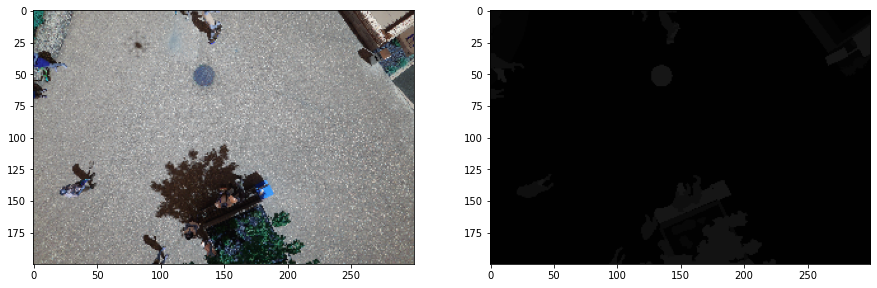

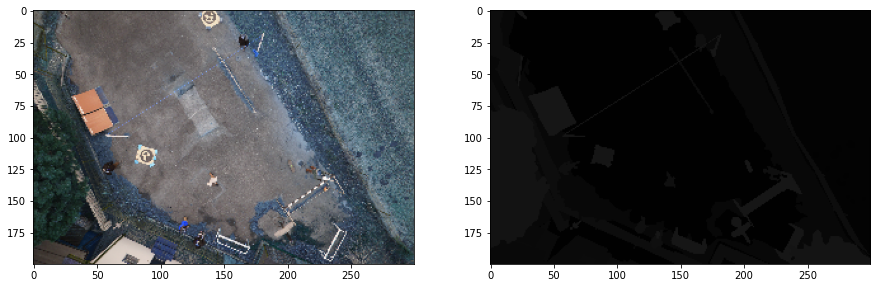

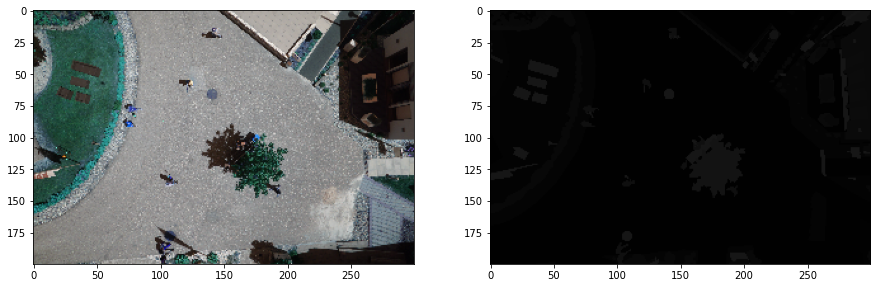

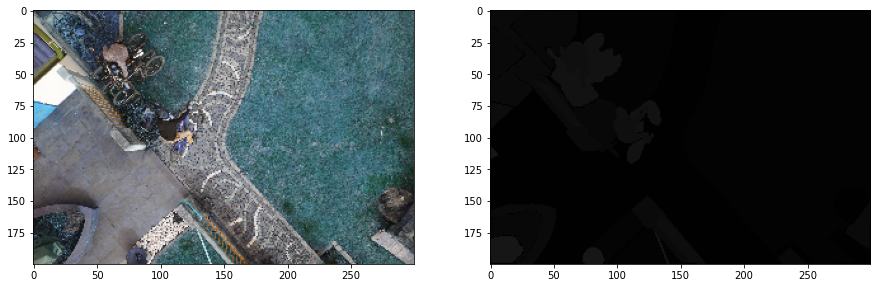

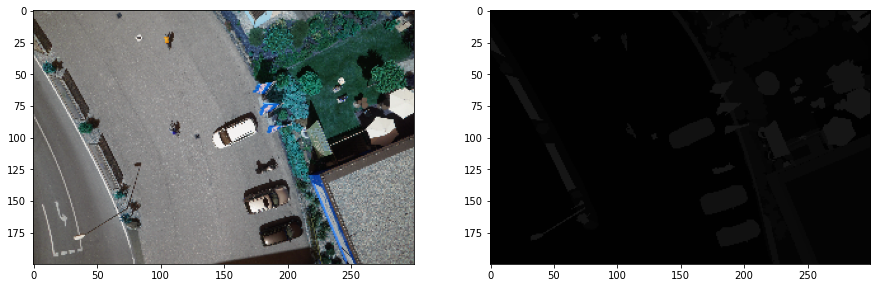

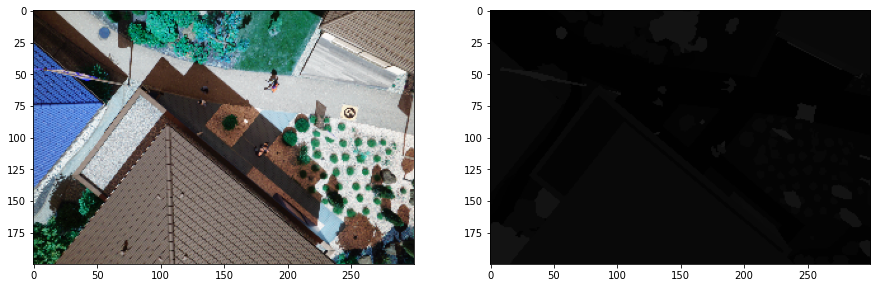

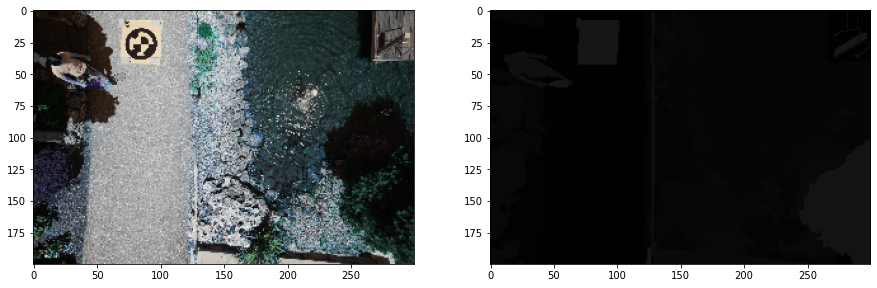

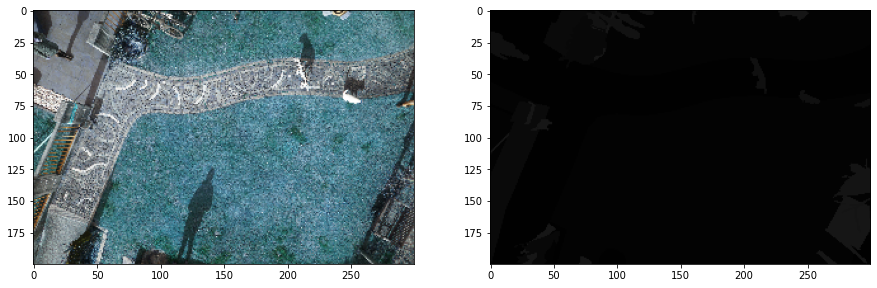

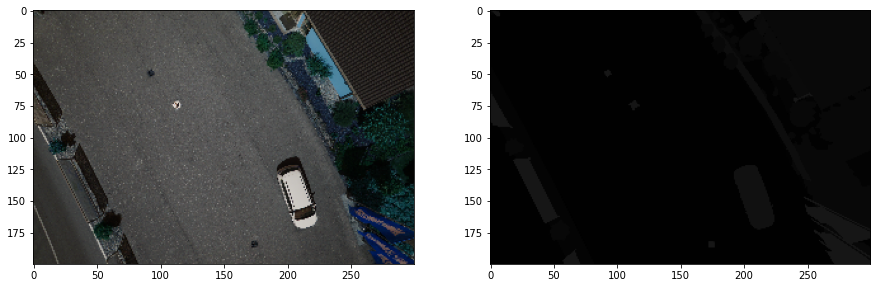

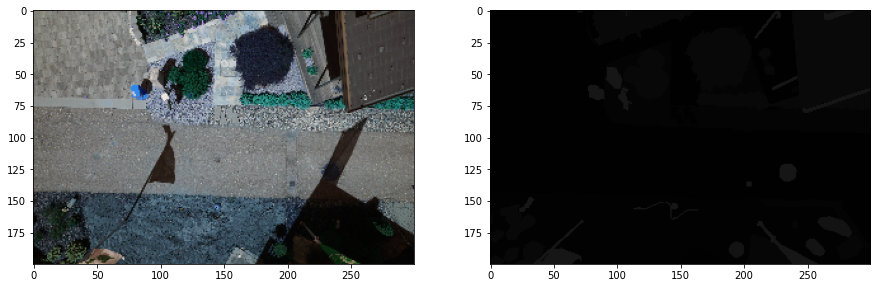

In [5]:
for i in range(10):
  display_images([images[i], labels[i]])

#Model


In [10]:
input_Layer = tf.keras.Input(shape=(train_images[0].shape))

resnet_layers = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=input_Layer)
resnet_layers.trainable = False

resnet_layers.summary()

#base_model = applications.VGG19(include_top=False, input_tensor=model_input, weights="imagenet")
#base_model.trainable = False







Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 306, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 150, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________